1. Обучите любую модель классификации на датасете IRIS до применения PCA и после него. Сравните качество классификации по отложенной выборке.

In [59]:
import numpy as np

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [61]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

X = X.astype(float)

X.shape, y.shape

((150, 4), (150,))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)
X_train.shape, y_train.shape

((112, 4), (112,))

In [63]:
X_train = standard_scale(X_train)
X_test = standard_scale(X_test)

In [64]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(f'Accuracy до понижения размерности данных: {accuracy_score(y_test, y_pred)}')

Accuracy до понижения размерности данных: 0.8947368421052632


In [65]:
# Найдем собственные векторы и собственные значения 
covariance_matrix = X.T @ X
eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(9208.305070314851, array([0.75110816, 0.38008617, 0.51300886, 0.16790754]))
(315.4543165767582, array([ 0.2841749 ,  0.5467445 , -0.70866455, -0.34367081]))
(11.978042904910822, array([ 0.50215472, -0.67524332, -0.05916621, -0.53701625]))
(3.552570203480874, array([ 0.32081425, -0.31725607, -0.48074507,  0.75187165]))


In [66]:
# Оценим долю дисперсии, которая описывается найденными компонентами.
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
cum_var_exp = np.cumsum(var_exp)
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[96.53029806531566, 3.3068951313646835, 0.12556535030291374, 0.037241453016743115]
Кумулятивная доля дисперсии по компонентам 
[ 96.53029807  99.8371932   99.96275855 100.        ]


In [67]:
# Мы отбросим последние две компоненты, оставив первые две.

# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])
print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.75110816  0.2841749 ]
 [ 0.38008617  0.5467445 ]
 [ 0.51300886 -0.70866455]
 [ 0.16790754 -0.34367081]]


In [68]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)
Z.shape

(150, 2)

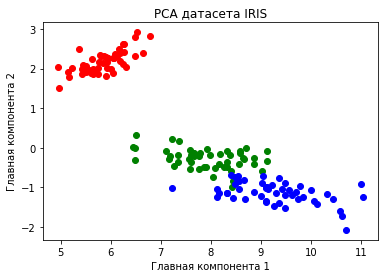

In [69]:
plt.figure()
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y == i, 0], Z[y == i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

In [70]:
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, random_state=7)
Z_train.shape, y_train.shape

((112, 2), (112,))

In [71]:
lr_after_pca = LogisticRegression()

lr_after_pca.fit(Z_train, y_train)

y_pred_after_pca = lr_after_pca.predict(Z_test)

print(f'Accuracy после понижения размерности данных: {accuracy_score(y_test, y_pred)}')

Accuracy после понижения размерности данных: 0.8947368421052632


In [72]:
# Accuracy до понижения размерности данных:  0.8947368421052632
# Вывод: метрику улучшить не удалось, поэтому лучше делать предсказания на всех данных, не снижая их размерности


2. Напишите свою реализацию метода главных компонент посредством сингулярного разложения с использованием функции numpy.linalg.svd().

In [73]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

X = X.astype(float)
X = standard_scale(X)

X.shape, y.shape

((150, 4), (150,))

 Вспомним, что сингулярное разложение матрицы - это разложение вида

$$X=UDV^{T},$$

- столбцы ортогональной матрицы $U$ - это собственные векторы матрицы $XX^{T}$
- столбцы ортогональной матрицы $V$ - собственные векторы матрицы $X^{T}X$
- на главной диагонали диагональной матрицы $D$ расположены собственные значения матриц $XX^{T}$ и $X^{T}X$ (они равны и также называются сингулярными числами матрицы $X$).

Для реализации понижения размерности методом главных компонент с помощью SVD нужно:
- найти сингулярное разложение $X^TX$;
- сформировать из столбцов матрицы $V$, соответствующих $d$ наибольшим сингулярным числам, матрицу весов $W$;
- получить новую матрицу "объекты-признаки", умножив исходную матрицу $X$ на матрицу весов $W$:

$$Z=XW.$$

In [99]:
covariance_matrix = X.T @ X
U, s, V_T = np.linalg.svd(covariance_matrix, full_matrices=False)
D = np.diag(s)

np.allclose(covariance_matrix, np.dot(U, np.dot(D, V_T)))

True

In [100]:
D

array([[437.77467248,   0.        ,   0.        ,   0.        ],
       [  0.        , 137.10457072,   0.        ,   0.        ],
       [  0.        ,   0.        ,  22.01353134,   0.        ],
       [  0.        ,   0.        ,   0.        ,   3.10722546]])

In [104]:
V_T.shape

(4, 4)

In [118]:
d = 2
W = np.hstack([V_T[i].reshape(4, 1)for i in range(d)])
W

array([[-0.52106591, -0.37741762],
       [ 0.26934744, -0.92329566],
       [-0.5804131 , -0.02449161],
       [-0.56485654, -0.06694199]])

In [119]:
Z = np.dot(X, W)
Z.shape

(150, 2)